# 1. Implement models in Stan (required)

### Import the libraries

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import pystan
import matplotlib.mlab as mlab


## 1.Call center data set — exponential likelihood with a gamma prior

In [87]:
"""
The first line imports the data as a data frame using Pandas.
The second and the third line are data pre-processing. Waiting times are calculated for each hour by 
extracting the time recorded for each row. 
"""
waiting_times_day = np.loadtxt('call_center.csv')
# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]

### Stan Code 

In [88]:
stan_code = """
data {  
    int<lower=1> N; // The number of inputs for each hour 
    real<lower=0> y[N];  //Waiting time 
    real<lower=0> alpha; 
    real<lower=0> beta;
}

parameters {
    real<lower=0> lambda; //
}

model {
    lambda ~ gamma(alpha, beta);  // prior over p
    for(i in 1:N) {
        y[i] ~ exponential(lambda);
  }
}
"""



In [89]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_770e82f0f1ae663b581cad4657616e9a NOW.


In [90]:
data = {'y': waiting_times_hour, #length of each waiting time
                      'N': len(waiting_times_hour), # number of waiting times in the data set
                      'alpha': 1,
                      'beta': 0.25
                   }
stan_results = stan_model.sampling(data=data)
# display model summary for lambda parameter
print(stan_results.stansummary(pars=['lambda'], probs=[0.01, 0.025, 0.5, 0.975, 0.99]))

Inference for Stan model: anon_model_770e82f0f1ae663b581cad4657616e9a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd     1%   2.5%    50%  97.5%    99%  n_eff   Rhat
lambda   6.36  8.7e-3   0.33   5.66   5.73   6.35   7.04   7.15   1415    1.0

Samples were drawn using NUTS at Fri Oct 18 22:03:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#### Posterior 98% confidence interval over λ

In [60]:
posterior_samples = stan_results.extract()
print("Posterior 98% confidence interval for lambda:", np.percentile(posterior_samples['lambda'], [1, 99]))

Posterior 98% confidence interval for lambda: [5.59395236 7.12780102]


#### Histogram of posterior λ samples

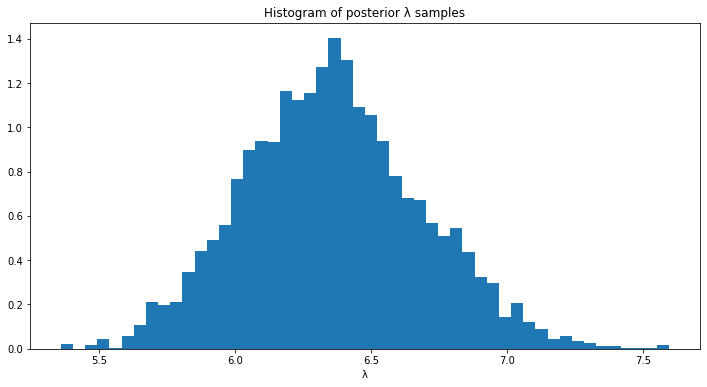

In [91]:
posterior_samples = stan_results.extract()
plt.figure(figsize=(12, 6))

plt.hist(posterior_samples['lambda'], bins=50, density=True)
plt.xlabel('λ')
plt.title('Histogram of posterior λ samples')
plt.show()

#### 2. Normal likelihood with normal-inverse-gamma prior.

In [62]:
stan_code = """
data {
   real mu;
   real nu;
   real<lower=0> alpha;
   real<lower=0> beta;
   int<lower=1> N;
   real y[N];
}

parameters {
    real mean1;
    real<lower=0> var1;
}
model {
   mean1 ~ normal(mu, sqrt(var1/nu));
   var1 ~ inv_gamma(alpha, beta);
   y ~ normal(mean1, sqrt(var1));
}
"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5113ce65f97ef3078ae8bcb7b8cad5cd NOW.


In [65]:
#This is the the array that contains the data used in the resources https://gist.github.com/cscheffler/2bde712fd73df281eac9311d7f5313bc#file-normal_inverse_gamma_solution-ipynb
arr = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])

In [66]:
# mu, nu, alpha and beta priors were given in previous class
data = {'N': len(arr), 'y': arr, 'mu': 0, 'nu':  0.054, 'alpha': 1.12, 'beta': 0.4,}

# train model on the data
stan_results = stan_model.sampling(data=data)

# display model summary for mean and variance
print(stan_results.stansummary(pars=['mean1', 'var1'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_5113ce65f97ef3078ae8bcb7b8cad5cd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mean1   3.06  2.3e-3   0.13   2.81   3.06   3.32   3487    1.0
var1    3.62  6.2e-3   0.37   2.94   3.59   4.38   3489    1.0

Samples were drawn using NUTS at Fri Oct 18 21:54:38 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


#### 95% posterior confidence intervals for the μ and variance σ of the log-transformed data. 

In [67]:
posterior_samples = stan_results.extract()
print("Posterior 95% confidence interval for the mean:", np.percentile(posterior_samples['mean1'], [2.5, 97.5]))
print("Posterior 95% confidence interval for variance:", np.percentile(posterior_samples['var1'], [2.5, 97.5]))

Posterior 95% confidence interval for the mean: [2.81100703 3.32352605]
Posterior 95% confidence interval for variance: [2.94453803 4.38412378]


#### Sampled posterior plot

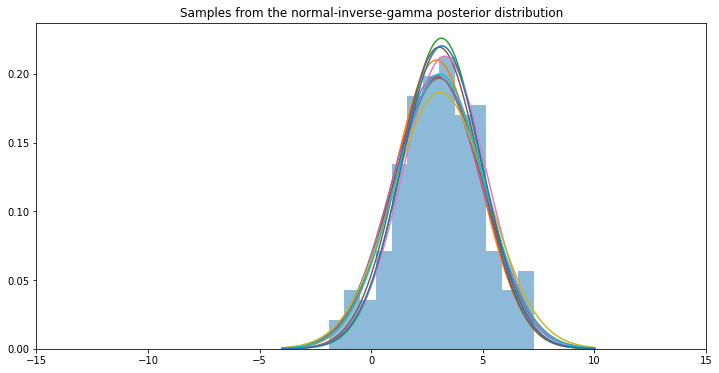

In [68]:
meanvars = np.array(list(zip(posterior_samples['mean1'], posterior_samples['var1'])))
plt.figure(figsize=(12, 6))

# display histogram
plt.hist(arr, density = True, bins = 13, alpha = 0.5, lw = 3)

x = np.linspace(-4, 10, 1000)

# choose 10 random rows from the matrix, and plot using mean and variance from each row
for i in meanvars[np.random.randint(0, 4000, 10), ]:
    plt.plot(x, ss.norm.pdf(x, i[0], np.sqrt(i[1])))

plt.title('Samples from the normal-inverse-gamma posterior distribution')
plt.xlim(-15, 15)
plt.show()

### 3. Log-normal HRTEM data. Normal likelihood log-transformed data and using a normal-inverse-gamma prior.



In [70]:
stan_code = """

data {
    real<lower=0> mu;
    real<lower=0> nu;
    real<lower=0> alpha;   // prior hyperparameters for gamma 
    real<lower=0> beta;   // prior hyperparameters for gamma 
    int<lower=0> n;   // length of data
    vector[n] data_set;   // data
}

parameters {
    real var1;
    real mean1;
}

model {
    var1 ~ inv_gamma(alpha, beta);
    mean1 ~ normal(mu, var1/nu);
    data_set ~ normal(mean1, sqrt(var1));
}

"""

normal_inverse_gamma_stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_42bad67532b7816474e7a088fc8c30e2 NOW.


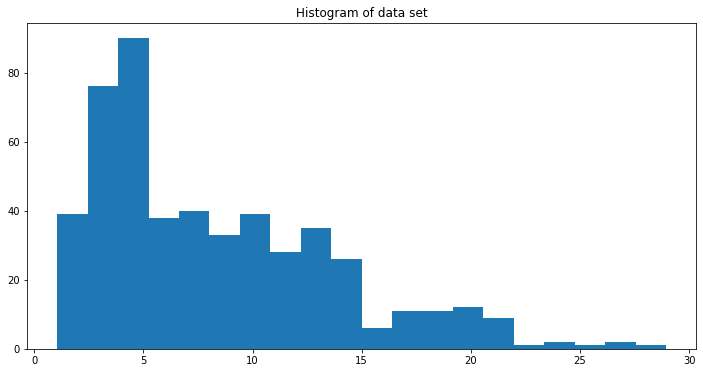

500 data, min: 1.051827, max: 28.942578


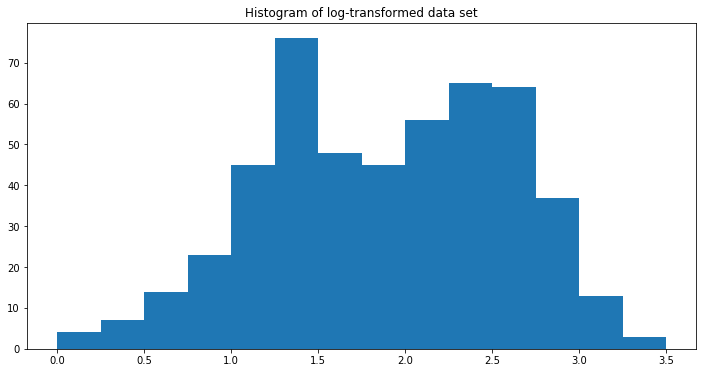

500 data, min: 0.050529, max: 3.365314


In [71]:
# load data
data = np.loadtxt('https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv')
plt.figure(figsize=(12,6))
plt.hist(data, bins=20)
plt.title('Histogram of data set')
plt.show()
print('%i data, min: %f, max: %f' % (len(data), min(data), max(data)))

# convert data into log data
log_data = np.log(data)
plt.figure(figsize=(12,6))

plt.hist(log_data, bins=np.linspace(0, 3.5, 15))
plt.title('Histogram of log-transformed data set')
plt.show()
print('%i data, min: %f, max: %f' % (len(log_data), min(log_data), max(log_data)))

#### 95% posterior confidence intervals for the μ and variance σ of the log-transformed data. 

In [72]:
stan_data = {
    "mu": 2.3,
    "nu": 0.1,
    "alpha": 2,
    "beta": 5,
    "n": len(log_data),
    "data_set": log_data,
}

results = normal_inverse_gamma_stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_42bad67532b7816474e7a088fc8c30e2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
var1     0.5  5.4e-4   0.03   0.44   0.47   0.49   0.52   0.56   3572    1.0
mean1   1.89  5.1e-4   0.03   1.83   1.87   1.89   1.91   1.95   3770    1.0
lp__  -76.13    0.03   1.04 -78.92  -76.5  -75.8 -75.39 -75.11   1652    1.0

Samples were drawn using NUTS at Fri Oct 18 21:56:16 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [73]:
posterior_samples = results.extract()
print("Posterior 95% confidence interval for the mean:", np.percentile(posterior_samples['mean1'], [2.5, 97.5]))
print("Posterior 95% confidence interval for the variance:", np.percentile(posterior_samples['var1'], [2.5, 97.5]))

Posterior 95% confidence interval for the mean: [1.82955584 1.95401292]
Posterior 95% confidence interval for the variance: [0.4365247  0.56234705]


#### Sampled posterior plot

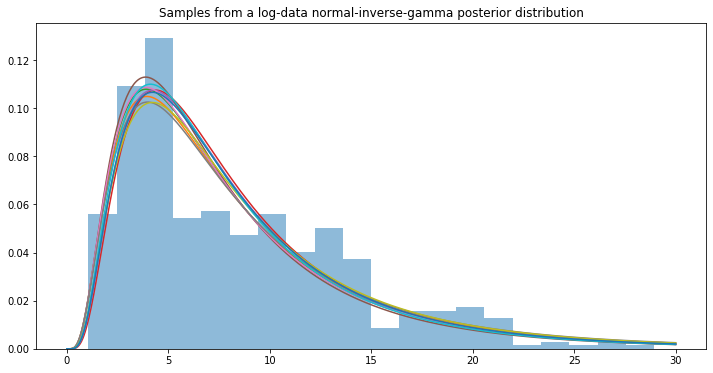

In [75]:
samples = results.extract()
plt.figure(figsize=(12,6))
plt.hist(data, bins = 20, density = True, alpha = 0.5, lw = 3)
num_samples = 10
plot_x = np.linspace(0, 30, 500)
for i in range(num_samples):
    plot_y = ss.lognorm.pdf(plot_x, np.sqrt(np.random.choice(samples['var1'], 1)), scale=np.exp(np.random.choice(samples['mean1'], 1)))
    plt.plot(plot_x, plot_y)
plt.title("Samples from a log-data normal-inverse-gamma posterior distribution")
plt.show()

# 2. Stretch goal (optional)

In [77]:
stan_code = """
data {
    int<lower=1> K; // Number of mixture parts/two Gaussians
    int<lower=1> N; // Size of the data
    real y[N]; // Observations
    real mu_prior; // The real values of the hyperparameters
    real<lower=0> nu;
    real<lower=0> alpha;
    real<lower=0> beta;
}
parameters {
    simplex[K] theta; // mixing proportions
    ordered[K] mu; // locations of mixture components
    vector<lower=0>[K] sigma;  // scales of mixture components
}
model {
    vector[K] log_theta = log(theta);  // cache log calculation
    mu ~ normal(mu_prior, sqrt(sigma/nu));
    sigma ~ inv_gamma(alpha, beta);

    for (n in 1:N) {
        vector[K] lps = log_theta;
        for (k in 1:K) {
            lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
        }
    target += log_sum_exp(lps);
    }
}

"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44e0a063fc9ab258b2961602e4baf30c NOW.


In [85]:
df = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv", header = None)
data = {'y':np.log(df.iloc[:,0]), 'N': len(df.iloc[:,0]), 'K':2, 'mu_prior': 2.3, 'nu': 0.1, 'alpha': 1, 'beta': 1}

# train model on data
stan_results = stan_model.sampling(data=data)

# output model summary
print(stan_results.stansummary(pars=['theta', 'mu', 'sigma'], probs=[0.025, 0.5, 0.975, 0.99]))

Inference for Stan model: anon_model_44e0a063fc9ab258b2961602e4baf30c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%    99%  n_eff   Rhat
theta[1]   0.58  2.2e-3   0.06   0.46   0.58   0.72   0.75    867    1.0
theta[2]   0.42  2.2e-3   0.06   0.28   0.42   0.54   0.56    867    1.0
mu[1]      1.44  3.0e-3   0.08    1.3   1.44   1.63   1.67    767   1.01
mu[2]      2.52  1.6e-3   0.05   2.41   2.52   2.62   2.65   1174    1.0
sigma[1]    0.5  1.7e-3   0.05   0.41    0.5   0.61   0.63    827   1.01
sigma[2]   0.35  8.4e-4   0.03   0.29   0.34   0.41   0.44   1466    1.0

Samples were drawn using NUTS at Fri Oct 18 22:01:15 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [79]:
posterior_samples = stan_results.extract()
print("Posterior 95% confidence interval for theta:", 
      np.transpose(np.percentile(posterior_samples['theta'], [2.5, 97.5], axis = 0))[0])
print("Posterior 95% confidence interval for mu1:", 
      np.transpose(np.percentile(posterior_samples['mu'], [2.5, 97.5], axis = 0))[0])
print("Posterior 95% confidence interval for mu2:", 
      np.transpose(np.percentile(posterior_samples['mu'], [2.5, 97.5], axis = 0))[1])
print("Posterior 95% confidence interval for sigma1:", 
      np.transpose(np.percentile(posterior_samples['sigma'], [2.5, 97.5], axis = 0))[0])
print("Posterior 95% confidence interval for sigma2:", 
      np.transpose(np.percentile(posterior_samples['sigma'], [2.5, 97.5], axis = 0))[1])

Posterior 95% confidence interval for theta: [0.46610734 0.70690967]
Posterior 95% confidence interval for mu1: [1.29314977 1.60050425]
Posterior 95% confidence interval for mu2: [2.41165793 2.61875237]
Posterior 95% confidence interval for sigma1: [0.41758951 0.59829735]
Posterior 95% confidence interval for sigma2: [0.2915268  0.41346925]


In [80]:
print("Posterior 98% confidence interval for theta:", 
      np.transpose(np.percentile(posterior_samples['theta'], [1, 99], axis = 0))[0])
print("Posterior 98% confidence interval for mu1:", 
      np.transpose(np.percentile(posterior_samples['mu'], [1, 99], axis = 0))[0])
print("Posterior 98% confidence interval for mu2:", 
      np.transpose(np.percentile(posterior_samples['mu'], [1, 99], axis = 0))[1])
print("Posterior 98% confidence interval for sigma1:", 
      np.transpose(np.percentile(posterior_samples['sigma'], [1, 99], axis = 0))[0])
print("Posterior 98% confidence interval for sigma2:", 
      np.transpose(np.percentile(posterior_samples['sigma'], [1, 99], axis = 0))[1])

Posterior 98% confidence interval for theta: [0.44719422 0.73413463]
Posterior 98% confidence interval for mu1: [1.27424441 1.63547593]
Posterior 98% confidence interval for mu2: [2.38543157 2.63759537]
Posterior 98% confidence interval for sigma1: [0.40480774 0.62466764]
Posterior 98% confidence interval for sigma2: [0.28121584 0.43262212]


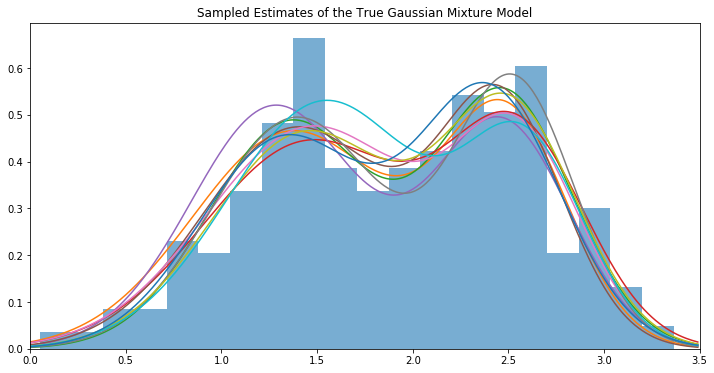

In [84]:
plt.figure(figsize=(12,6))

plt.hist(np.log(df.iloc[:,0]), bins=20, density=True, alpha = 0.6)

x = np.arange(0, 3.5, 0.01)

# use zip and list like previously, then convert to numpy object
thetamusigma = np.array(list(zip(posterior_samples['theta'], posterior_samples['mu'], posterior_samples['sigma'])))

# choose 10 random lists, each unit is a 3 X 2 matrix
for i in thetamusigma[np.random.randint(0, 4000, 10), ]:

    # Transpose each unit to a 2 X 3 matrix so that list comprehension can be used to generate the pdfs
    pdfs = [theta * ss.norm.pdf(x, mu, sigma) for theta, mu, sigma in np.transpose(i)]
    plt.plot(x, np.sum(np.array(pdfs), axis=0))
# We can see that the posterior is bimodal which confirms a mixture model 
#like this one since the posterior is always bimodal    
plt.title("Sampled Estimates of the True Gaussian Mixture Model")
plt.xlim(0, 3.5)
plt.show()